# Beijing Air Quality Forecasting Starter Notebook

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import seaborn as sns

In [14]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/ALU/BSE/Machine_Learning/Datasets/Kaggle_Competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ALU/BSE/Machine_Learning/Datasets/Kaggle_Competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [17]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [19]:
# Check the dimensionality of the training Data
train.shape

(30676, 12)

In [22]:
# Check the columns
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [23]:
# Check the data types of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [24]:
# Gain descriptive statistics for all numeric columns
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [25]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [27]:
#Skewness & Kurtosis
print("Skewness:", train['pm2.5'].skew())
print("Kurtosis:", train['pm2.5'].kurt())

Skewness: 1.8059885615490436
Kurtosis: 5.0973294897056824


In [28]:
#Percentile Analysis (Outliers Detection)
train['pm2.5'].quantile([0.01, 0.25, 0.5, 0.75, 0.99])

,pm2.5
0.01,7.0
0.25,29.0
0.50,75.0
0.75,142.0
0.99,429.0


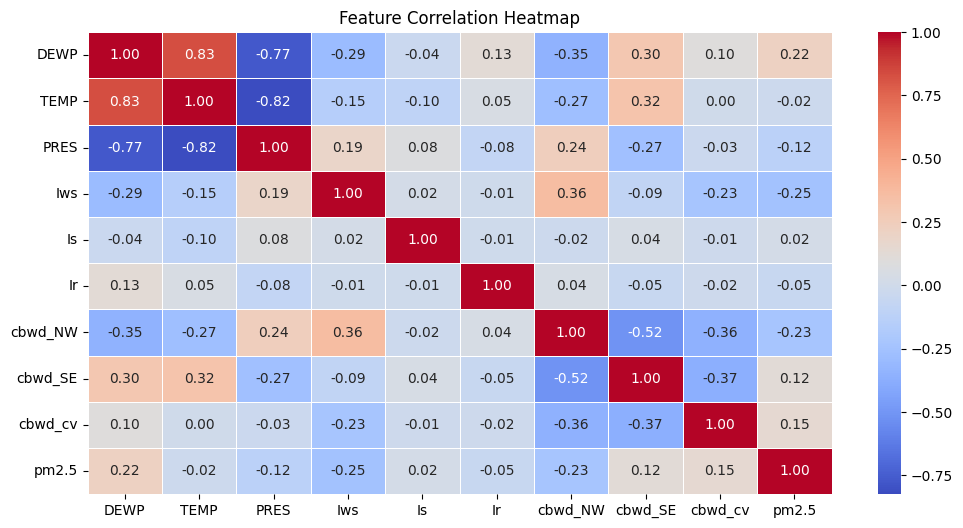

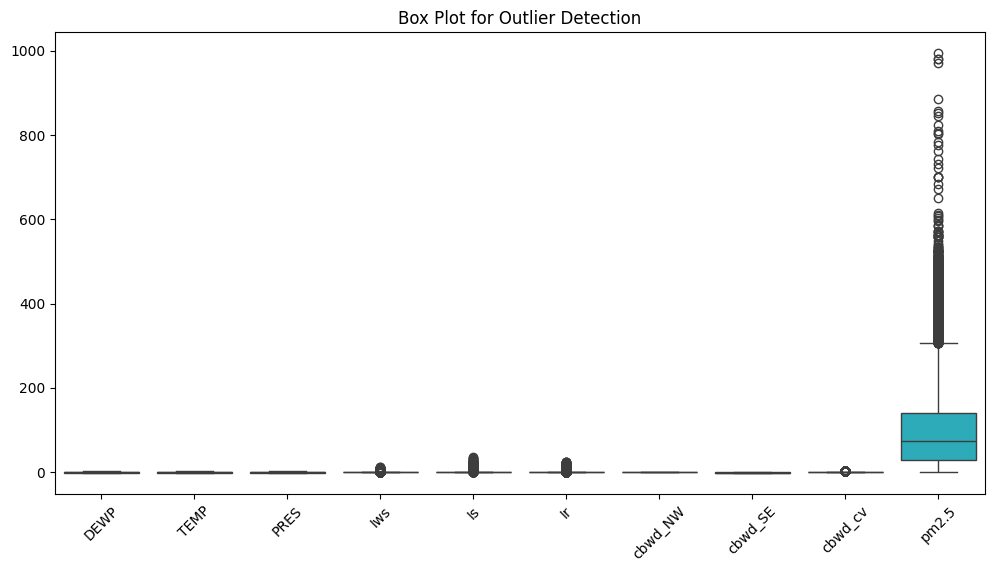

In [34]:
#HeatMap for the Dataset
# Computing the correlation matrix
corr_matrix = train.drop(columns=['No']).corr()  # Exclude non-numeric columns

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Plot boxplots for all numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(train.drop(columns=['No']))
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection")
plt.show()



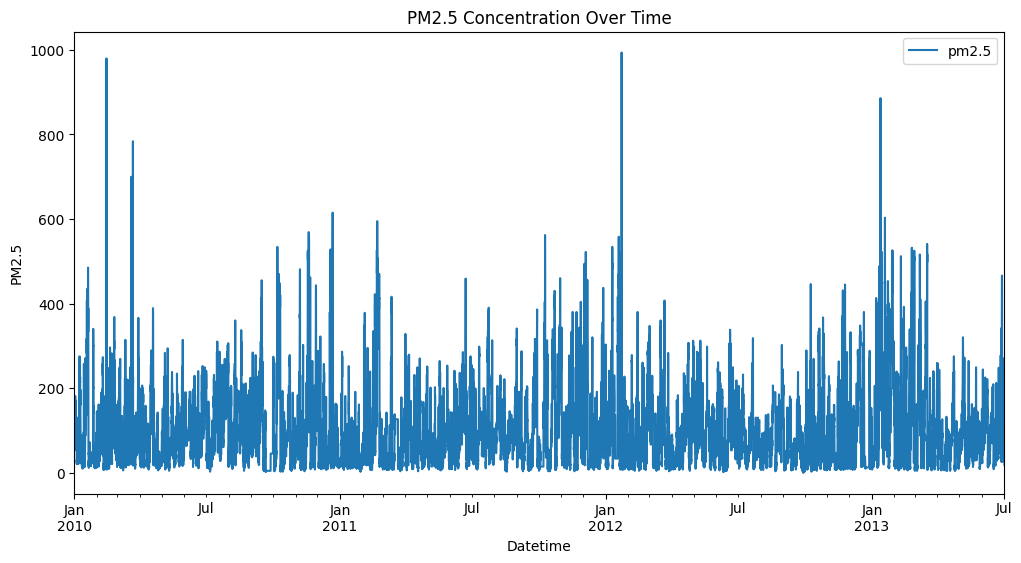

In [35]:
# Line Plot PM2.5 over time
train.plot(y='pm2.5', figsize=(12,6), title="PM2.5 Concentration Over Time")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.show()

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [26]:
#Identifying Mising Value
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [30]:
# Used forward fill and backward fill to improve missing value handling
train.ffill(inplace=True) # Forward fill missing values
train.bfill(inplace=True) # Backward fill any remaining


In [31]:
#Cross check if there are no more mising Value
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [36]:
# Separate features (X) and target (y)
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [37]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [38]:
# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 127.3751 - loss: 16852.8086
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 91.6845 - loss: 8945.6338
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 82.4128 - loss: 7226.6548
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 76.7533 - loss: 6263.0054
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 75.0146 - loss: 5924.5015
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 73.9992 - loss: 5854.6069
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 75.1350 - loss: 5980.6914
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 74.2454 - loss: 5846.5840
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 73.1694 - loss: 5682.4946
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 73.1647 - loss: 5673.3364


In [41]:
# Model 1: Deeper Architecture with two LSTM layers
model1 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1)
])

# Compile the model
model1.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Train the model1
# Ajusting the number of epochs and batch size to improve performance.
history1 = model1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=30
)

Epoch 1/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 65.9970 - loss: 4621.0049
Epoch 2/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 66.2760 - loss: 4650.5728
Epoch 3/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 65.3037 - loss: 4520.1572
Epoch 4/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 66.6371 - loss: 4737.2529
Epoch 5/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 65.4447 - loss: 4524.5127
Epoch 6/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 65.4934 - loss: 4527.7104
Epoch 7/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - lambda: 65.7253 - loss: 4588.2563
Epoch 8/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 66.0228 - loss: 4638.2300
Epoch 9/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 66.4007 - loss: 4679.2715
Epoch 10/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - lambda: 65.7186 - loss: 4577.5000
Epoch 11/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 66.0426 - loss: 4641.3228
Epoch 12

In [46]:
# Model 2: Increased Units
model2 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model2.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Train the model2
# Ajusting the number of epochs and batch size to improve performance.
history2 = model2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=40
)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 71.1004 - loss: 5270.2202
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 70.4534 - loss: 5175.8906
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 69.7611 - loss: 5111.9570
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 69.9976 - loss: 5144.7930
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 70.9556 - loss: 5243.7754
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 69.7698 - loss: 5099.2861
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 70.4508 - loss: 5240.3398
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 71.8092 - loss: 5459.7124
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 70.3013 - loss: 5170.5356
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 70.4248 - loss: 5175.2754
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 70.6766 - loss: 5236.1470
Epoch 12/50
767/767 ━━━━━━━━━━

In [48]:
# Model 3: Different Optimizer (RMSprop)
model3 = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model3.compile(
    optimizer='RMSprop',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Train the model3
# Ajusting the number of epochs and batch size to improve performance.
history3 = model3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=20
)

Epoch 1/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 69.4487 - loss: 5277.8271
Epoch 2/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 69.6652 - loss: 5292.0117
Epoch 3/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 70.4803 - loss: 5403.3882
Epoch 4/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 70.2271 - loss: 5316.7422
Epoch 5/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 70.7830 - loss: 5478.7231
Epoch 6/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 70.3524 - loss: 5347.5034
Epoch 7/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 70.1229 - loss: 5376.6074
Epoch 8/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - lambda: 70.7448 - loss: 5488.0679
Epoch 9/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lambda: 70.1076 - loss: 5317.1968
Epoch 10/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 69.6723 - loss: 5207.1147
Epoch 11/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lambda: 69.5793 - loss: 5265.1592
Epoch 12

In [50]:
# Model 4: Deeper and Wider Architecture
model4 = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
model4.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model4.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 1, 100)         │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,251 (290.04 KB)

 Trainable params: 74,251 (290.04 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Train the model4
# Ajusting the number of epochs and batch size to improve performance.
history4 = model4.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - lambda: 104.1775 - loss: 11895.3096
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 73.8897 - loss: 5776.8169
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 73.4549 - loss: 5702.2324
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - lambda: 73.0196 - loss: 5643.0415
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 73.5414 - loss: 5700.0952
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 72.9428 - loss: 5595.4023
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 71.9907 - loss: 5514.2285
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 71.2008 - loss: 5347.9746
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 70.9413 - loss: 5278.1108
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 70.1714 - loss: 5200.1416


In [52]:
# Model 5: Smaller Network
model5 = Sequential([
    LSTM(16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model5.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model5.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 16)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the model5
# Ajusting the number of epochs and batch size to improve performance.
history5 = model5.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 129.1985 - loss: 17310.8105
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 96.0892 - loss: 9768.6230
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 83.8608 - loss: 7477.9790
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 78.0465 - loss: 6477.3604
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 76.2276 - loss: 6129.4702
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 74.8861 - loss: 5929.4111
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 74.3911 - loss: 5857.2012
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 74.0140 - loss: 5749.1860
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 73.7848 - loss: 5752.4399
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 73.5226 - loss: 5757.0122


In [54]:
from tensorflow.keras.layers import Dropout

# Model 6: Adding a Dropout Layer
model6 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # Dropout layer
    Dense(1)
])

# Compile the model
model6.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model6.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the model6
# Ajusting the number of epochs and batch size to improve performance.
history6 = model6.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 121.9816 - loss: 15485.0771
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lambda: 87.1717 - loss: 7958.3906
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 79.5246 - loss: 6723.9790
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 76.9757 - loss: 6292.5142
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 75.6901 - loss: 6110.4243
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 75.5023 - loss: 6047.5361
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 74.4931 - loss: 5858.4658
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 74.2823 - loss: 5840.3110
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 75.0383 - loss: 5994.1138
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 74.6757 - loss: 5922.2051


In [56]:
# Model 7: Deeper with Dropout
model7 = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model7.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model7.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 1, 100)         │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,251 (290.04 KB)

 Trainable params: 74,251 (290.04 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train the model7
# Ajusting the number of epochs and batch size to improve performance.
history7 = model7.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - lambda: 105.3286 - loss: 12154.7529
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 75.6233 - loss: 6046.5591
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 75.8089 - loss: 6092.5015
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 73.6885 - loss: 5732.6235
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 73.8028 - loss: 5732.3745
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 72.9584 - loss: 5643.7700
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.2257 - loss: 5487.4009
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 72.9281 - loss: 5623.0869
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 70.6525 - loss: 5302.0796
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - lambda: 72.6165 - loss: 5582.4707


In [58]:
# Model 8: Increased Hidden Layer Units
model8 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'), # Hidden dense layer
    Dense(1)
])

# Compile the model
model8.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model8.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train the model8
# Ajusting the number of epochs and batch size to improve performance.
history8 = model8.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 107.8856 - loss: 12480.4629
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 77.0792 - loss: 6303.9531
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 74.9524 - loss: 5934.7017
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 74.4790 - loss: 5839.7280
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 72.8643 - loss: 5614.9375
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 73.4343 - loss: 5685.1235
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 73.5902 - loss: 5712.3667
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lambda: 71.8466 - loss: 5461.9307
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 71.3073 - loss: 5366.8989
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 72.3372 - loss: 5531.2441


In [60]:
# Model 9: tanh Activation Function
model9 = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model9.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model9.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Train the model9
# Ajusting the number of epochs and batch size to improve performance.
history9 = model9.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 130.8866 - loss: 17762.8379
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 111.5328 - loss: 13055.5010
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 95.3222 - loss: 9666.9062
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 87.1656 - loss: 8095.0630
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 82.9939 - loss: 7347.0215
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 79.7796 - loss: 6778.9692
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 77.9596 - loss: 6493.4971
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 76.8887 - loss: 6302.7368
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 75.2199 - loss: 6008.9736
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 74.7655 - loss: 5943.1523


In [62]:
from tensorflow.keras.layers import Bidirectional

# Model 10: Bidirectional LSTM
model10 = Sequential([
    Bidirectional(LSTM(32, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model10.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model10.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Train the model10
# Ajusting the number of epochs and batch size to improve performance.
history10 = model10.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 123.6543 - loss: 15988.1318
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 85.2900 - loss: 7729.4932
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 78.6609 - loss: 6546.8711
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 75.7826 - loss: 6062.5273
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 74.4916 - loss: 5861.4170
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 73.4800 - loss: 5725.4941
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 74.0415 - loss: 5834.2207
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 73.0615 - loss: 5615.9258
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - lambda: 73.7940 - loss: 5781.2559
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 72.6544 - loss: 5600.3306


In [91]:
# Model 11: Deeper Bidirectional LSTM
model11 = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(32, activation='relu')),
    Dense(1)
])

# Compile the model
model11.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model11.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 1, 128)         │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,169 (309.25 KB)

 Trainable params: 79,169 (309.25 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Train the model11
# Ajusting the number of epochs and batch size to improve performance.
history11 = model11.fit(
    X_train, y_train,
    epochs=150,
    batch_size=30
)

Epoch 1/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - lambda: 99.0280 - loss: 10794.2539
Epoch 2/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 73.6274 - loss: 5756.5068
Epoch 3/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.4896 - loss: 5585.9287
Epoch 4/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 71.2554 - loss: 5354.4282
Epoch 5/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.3643 - loss: 5520.5371
Epoch 6/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - lambda: 72.0578 - loss: 5521.4458
Epoch 7/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - lambda: 70.9963 - loss: 5367.0605
Epoch 8/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 71.6164 - loss: 5443.2954
Epoch 9/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - lambda: 71.1863 - loss: 5386.1460
Epoch 10/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 71.2105 - loss: 5363.6577
Epoch 11/150
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.1441 - loss: 5563.

In [66]:
from tensorflow.keras.layers import GRU

# Model 12: GRU
model12 = Sequential([
    GRU(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model12.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model12.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train the model12
# Ajusting the number of epochs and batch size to improve performance.
history12 = model12.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 124.8470 - loss: 16254.4678
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 85.5802 - loss: 7794.9370
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 79.1958 - loss: 6659.9438
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 75.4346 - loss: 6043.9443
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 74.4329 - loss: 5870.4937
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 73.0426 - loss: 5643.9707
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 74.2440 - loss: 5838.1914
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 73.9009 - loss: 5761.7212
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 72.9520 - loss: 5668.7617
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 73.8770 - loss: 5758.0796


In [68]:
# Model 13: Deeper GRU Network
model13 = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    GRU(32, activation='relu'),
    Dense(1)
])

# Compile the model
model13.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model13.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 1, 64)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,841 (93.13 KB)

 Trainable params: 23,841 (93.13 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train the model13
# Ajusting the number of epochs and batch size to improve performance.
history13 = model13.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - lambda: 103.5777 - loss: 11630.3105
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 74.1729 - loss: 5803.0117
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 73.1808 - loss: 5663.5303
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 72.0711 - loss: 5487.9443
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 72.3299 - loss: 5514.1792
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 72.3595 - loss: 5554.5474
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - lambda: 71.5090 - loss: 5415.1978
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 71.7222 - loss: 5452.6626
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 71.8152 - loss: 5443.3188
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 72.1157 - loss: 5542.6567


In [70]:
# Model 14: Increased Batch Size
model14 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model14.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Example of a training command with a different batch size
# history14 = model14.fit(X_train_seq, y_train_seq, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

# Display the model architecture
model14.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Train the model14
# Ajusting the number of epochs and batch size to improve performance.
history14 = model14.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lambda: 124.7450 - loss: 16330.2188
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 85.0149 - loss: 7658.5396
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 76.9775 - loss: 6305.5674
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 74.9290 - loss: 5947.3828
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 73.2614 - loss: 5646.6396
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 74.3275 - loss: 5855.2554
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 73.8697 - loss: 5752.2144
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 73.4083 - loss: 5694.8955
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 73.5034 - loss: 5720.3159
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - lambda: 73.0938 - loss: 5660.7939


In [72]:
from tensorflow.keras.optimizers import Adam

# Model 15: Reduced Learning Rate
adam_optimizer = Adam(learning_rate=0.0001)

model15 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model15.compile(
    optimizer=adam_optimizer,
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model architecture
model15.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Train the model15
# Ajusting the number of epochs and batch size to improve performance.
history15 = model15.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 132.6808 - loss: 18147.5684
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 131.3185 - loss: 17792.5820
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 127.1714 - loss: 16719.9316
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 120.8805 - loss: 15175.5557
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 115.8106 - loss: 14060.0605
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 107.8385 - loss: 12178.1729
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lambda: 101.6286 - loss: 10904.9824
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 98.5584 - loss: 10291.0596
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 94.4152 - loss: 9535.1162
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 91.2989 - loss: 8829.6699


959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


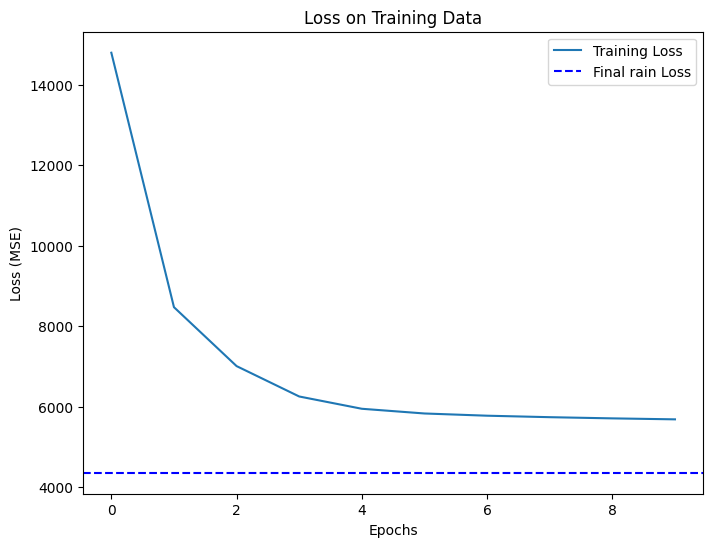

Final Training Loss (MSE): 4357.8093861882135


In [83]:
# Calculate training loss
train_predictions = model11.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [85]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model11.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/ALU/BSE/Machine_Learning/Datasets/Kaggle_Competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
